# Single Allocation Capacitated Facility Location Problem.
### Autor: Saúl Sosa Díaz
---
## El problema.
El Single Allocation Capacitated Facility Location Problem (SACFLP) es una compleja problemática dentro de la investigación operativa y logística, enfocada en la asignación óptima de clientes a instalaciones, bajo la premisa de capacidades limitadas y la minimización de costos. Su objetivo es la selección estratégica de ubicaciones para instalar estas facilidades, asignando a cada cliente a una única instalación, de manera que se reduzcan tanto los costos de establecimiento como los operativos. Las restricciones de capacidad son cruciales, ya que cada instalación tiene un límite máximo que no debe sobrepasarse, asegurando que la demanda de los clientes asignados no exceda esta capacidad.

El SACFLP implica costos de dos índoles: el de instalación, referente a la apertura y mantenimiento de la facilidad, y el de transporte, vinculado al servicio a los clientes desde las instalaciones asignadas. Este último usualmente varía según la distancia o el tiempo de viaje entre las instalaciones y los clientes. Su relevancia se extiende a diversas áreas, como la planificación de redes de distribución, ubicación de almacenes, y centros de distribución, así como en la planificación de infraestructuras de servicios.

Por tanto, se tiene un grupo $I$ de $n$ clientes y otro grupo $J$ de $m$ ubicaciones potenciales para fábricas. Cada cliente, designado como $i$ en el grupo $I$, tiene una demanda especificada $d_i$. En paralelo, cada fábrica, marcada como $j$ en el conjunto $J$, conlleva un costo asociado $f_j$ y una capacidad máxima de producción $q_j$. Además, se conoce el costo $c_{ij}$ de transporte por cada unidad de demanda del cliente $i$ que es atendida por la fábrica $j$.

Teniendo estos datos el problema se podría modelar de la siguiente manera.

**Variables**
 
 * $x_{ij}$ es una variable continua que representa la cantidad de demanda del cliente $i$ satisfecha por la fábrica $j$. $\forall i \in I \land \forall j \in J$
 * $z_{ij}$ es una variable binaria que representa si el cliente $i$, está servido por la fábrica $j$. $\forall i \in I \land \forall j \in J$
 * $y_j$ es una variable binaria que representa si la fábrica $j$ ha sido abierta, siendo 1 este indicativo. $\forall j \in J$      

**Función objetivo**
Formalmente, se busca:
$$
    \begin{array}{ccc}
        &\min \sum_{j \in J}f_j y_j + \sum_{i \in I}\sum_{j \in J} c_{ij} x_{ij} z_{ij}
    \end{array}
$$

sujeto a:
$$
    \begin{array}{ccc} &\\ 
        &  x_{ij} = d_i z_{ij}   & \forall  i \in I \land  \forall j \in J \\
        & \sum_{i \in I} x_{ij} \leq q_j y_j & \forall  j \in J  \\
        & \sum_{j \in J} z_{ij} = 1 & \forall  i \in I  \\
        & x_{ij} \geq 0                    & \forall  i \in I \land  \forall j \in J \\
        & y_j \in \{ 0,1 \}                & \forall  j \in J \\
        & z_{ij} \in \{ 0,1 \}                & \forall  i \in I \land  \forall j \in J
    \end{array}
$$


## Resolución del problema.
Importamos los paquetes necesarios.

In [1]:
import Pkg
Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("Plots")


using JuMP, GLPK, Random, Plots, Random, LinearAlgebra



### Introducimos los datos.

In [ ]:
n = 25   # number of clients
m = 6    # number of factory locations

Random.seed!(456)

Xf, Yf = rand(0:100,m), rand(0:100,m)   # Factory potential locations
Xc, Yc = rand(0:100,n), rand(0:100,n)   # Clients' locations
factory_location = [Xf,Yf]
client_location  = [Xc,Yc]
cost  = zeros(Float32,n,m)  # cost per unit from factory to customer

for i=1:n, j=1:m
    cost[i, j] = round(sqrt( (Xf[j] - Xc[i])^2 +(Yf[j] - Yc[i])^2 ),digits=0)
end

fixed  = rand(20:30 , m)     # Fixed costs on factories
supply = rand(15:20, m)      # Supply for factories
demand = rand(1:5, n)        # Demands for customers

if sum(supply) < sum(demand) 
    println("There is insufficient availability in the factories and excessive demand from the customers!!!")
    println("Availability =", sum(supply), " Demand =", sum(demand))
    p = sum(supply) / sum(demand)   # An alternative to produce a feasible problem may be to reduce the served demand!
    demand = floor.(demand ./ p)
end

Preparamos la representación de los datos.

In [ ]:
function DrawInstance(client_location,factory_location,supply,demand)
    Xc = client_location[1]
    Yc = client_location[2]
    Xf = factory_location[1]
    Yf = factory_location[2]
    p = scatter( # Plot the clients
        Xc,
        Yc;
        label = nothing,
        markershape = :circle,
        markercolor = :green,
        markersize = 2 .* (2 .+ demand)
    )
    scatter!( # Plot the factories
        Xf,
        Yf;
        label = nothing,
        markershape = :star5,
        markercolor = :yellow,
        markersize = supply,
        markerstrokewidth = 2,
    )


    display(p)
end

function DrawSolution(x,y,client_location,factory_location,supply,demand)
    Xc = client_location[1]
    Yc = client_location[2]
    Xf = factory_location[1]
    Yf = factory_location[2]
    p = scatter( # Plot the clients
        Xc,
        Yc;
        label = nothing,
        markershape = :circle,
        markercolor = :green,
        markersize = 2 .* (2 .+ demand)
    )
    scatter!( # Plot the factories
        Xf,
        Yf;
        label = nothing,
        markershape = :star5,
        markercolor = :yellow,
        markersize = supply,
        markerstrokewidth = 2,
    )

    # Plot the connections
    for i in 1:n, j in 1:m 
        if x[i, j] > 1e-5
            plot!(
                [Xf[j], Xc[i]],
                [Yf[j], Yc[i]];
                color =  :blue,
                label = nothing,
                )
            end
        end
    display(p)
end


DrawSolution (generic function with 1 method)

Mostramos el mapa visualmente. Donde las estrellas representan la ubicación de nuestras fábricas y los cículos representan nuestros clientes. Es importante recalcar que el tamaño de estos puntos son respectivos a sus suministros y a su demanda respectivamente.

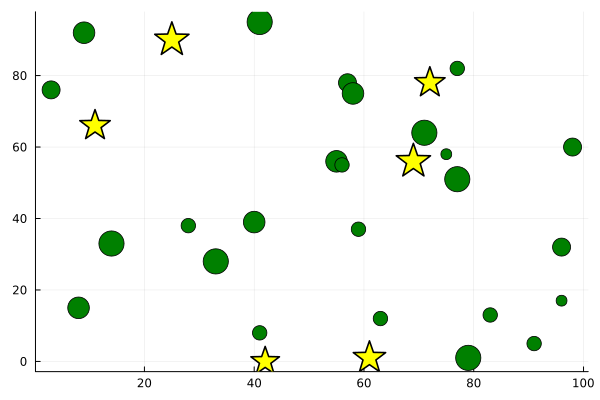

In [ ]:
DrawInstance(client_location,factory_location,supply,demand)

### Construir el modelo.

In [ ]:
function solveCRPC(N, M, cost, F, D, Q)
    EPS = 0.00001
    model = Model(GLPK.Optimizer)
    set_silent(model)

    # Variables
    @variable(model, x[1:N, 1:M] >= 0)
    @variable(model, Z[1:N, 1:M], Bin)
    @variable(model, y[1:M], Bin)

    # Objective
    @objective(model, Min, sum(F .* y) + sum(cost .* x))

    # Constraints
    @constraint(model, [i=1:N, j=1:M], x[i, j] == D[j] * Z[i, j]) # Demand constraint
    @constraint(model, [j=1:M], sum(x[:, j]) <= Q[j] * y[j]) # Capacity constraint
    @constraint(model, [i=1:N], sum(Z[i, :]) == 1) # Assignment constraint

    optimize!(model)

    # Show solutions
    if termination_status(model) == OPTIMAL
        print("Optimal obj value: ", objective_value(model), "  = ", fixed'value.(y), " (from factories) + ", sum(cost .* value.(x)), " (from clients)")
        println("  Open factorys: ", value.(y))
        DrawSolution(value.(x), value.(y), client_location, factory_location, supply, demand)

    else
        println("infeasible")
        return -1
    end
end


solveCRPC (generic function with 1 method)

Resolvemos y mostramos el resultado.

Optimal obj value: 1021.0  = 126.0 (from factories) + 895.0 (from clients)  Open factorys: [0.0, 1.0, 1.0, 1.0, 1.0, 1.0]


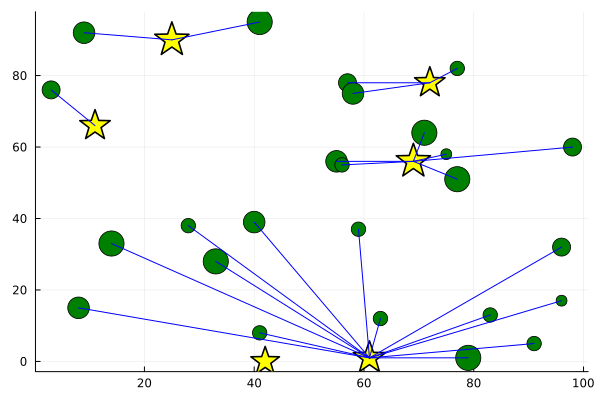

In [ ]:
solveCRPC(n,m,cost,fixed,demand,supply)

Observamos en la solución que solo 5 de los 6 almacenes están abiertos. Esta configuración resulta en un costo total de 1021 euros para abastecer a todos los clientes.